# Mapping Chemical Space with UMAP

**Content**:
- Create 2D visualization of Blood Brain Barrier Permeability (BBBP) dataset with UMAP
- Embed compounts of interest into the embedding

**The dataset**:  
The BBBP (Blood-Brain Barrier Penetration) dataset from [MoleculeNet](https://moleculenet.org/datasets-1) contains information on compounds and their ability to penetrate the blood-brain barrier, which is crucial for drug discovery and development.

**The method**:  
The UMAP method is an example of *unsupervised* machine learning that can embed high dimensional data in a lower dimensional space. Its advantages are that it preserves the local and global structure of the data.

**Methodology**:
- This notebook has gaps (marked with a `#TODO`) that you have to fill. 
- If all gaps are filled in correctly, the notebook cells can be run.
- A solution notebook with all gaps filled is provided in the GitHub repository.

This notebook has been created being inspired by or using content from [Source Notebook on Google Colab](https://colab.research.google.com/gist/ElanaPearl/444b3331f61485bbe8862db27cb2b968/mapping-chemical-space-with-umap.ipynb#scrollTo=dzmJAwfiAi6k)

## 1. Import libraries and format data
Here all necessary libraries are imported and the necessary data is fetched.

- `os`: Provides functions to interact with the operating system, such as checking file existence.
- `pandas`: Used for data manipulation and analysis.
- `numpy`: Provides support for numerical computations.
- `seaborn`: A visualization library based on matplotlib for statistical graphics.
- `matplotlib.pyplot`: A plotting library for creating static, animated, and interactive visualizations.
- `rdkit`: A toolkit for cheminformatics, used for handling chemical information.
- `sklearn`: A machine learning library for data analysis and modeling.
- `umap.umap_`: A library for dimensionality reduction using UMAP (Uniform Manifold Approximation and Projection).

In [1]:
# install packages that are not available in google colab
%pip install rdkit

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit
import sklearn
import umap.umap_ as umap

from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

In [3]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

We also define the following three helper functions that we need later in the notebook.

In [4]:
def get_largest_fragment_from_smiles(s: str):
    """
    Get the largest fragment from a SMILES string.
    Args:
        s: SMILES string
    Returns:
        str: SMILES string of the largest fragment
    """
    mol = rdkit.Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return rdkit.Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list):
    """ 
    Computes ecfp descriptors for a list of SMILES strings.
    Args:
        smiles_list: list of SMILES strings
    Returns: 
        np.array: ECFP descriptors
        list: list of indices of the SMILES strings that were successfully converted
    """

    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    """"
    Computes ECFP descriptors for a single SMILES string.
    Args:
        smiles: SMILES string
    Returns:
        np.array: ECFP descriptors
    """
    try:
        mol = rdkit.Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)

    return None

Load BBBP dataset from the internet if neccesary (For example if this notebook is used in a Google colab, the data has to be retrieved and saved from the online GitHub repository).

In [5]:
import urllib.request

if not os.path.exists('data/BBBP.csv'):
    os.makedirs('data', exist_ok=True)
    url = "https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/BBBP.csv"
    urllib.request.urlretrieve(url, "data/BBBP.csv")
    print("Data loaded from URL and saved locally")

bbbp = pd.read_csv("data/BBBP.csv")
bbbp.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


### Format the BBBP dataset
- Change column names for easier interpretability
- remove extra fragments in the SMILES representation that is irrelevant for the brain-blood-barrier permeability (typically salts)


In [6]:
# Clean up columnn names so they are easier to interpret
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

#reorder columns
bbbp = bbbp[["name", "smiles", "permeable"]]

# Remove extra fragments in SMILES 
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()

pd.DataFrame(bbbp).head(10)

,name,smiles,permeable
0,Propanolol,CC(C)NCC(O)COc1cccc2ccccc12,1
1,Terbutylchlorambucil,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1
2,40730,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1
3,24,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1
4,cloxacillin,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1
5,cefoperazone,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3C(C(=...,1
6,rolitetracycline,CN(C)[C@@H]1C(=O)/C(=C(/O)NCN2CCCC2)C(=O)[C@@]...,1
7,ondansetron,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O,1
8,diltiazem,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,1
9,Amiloride,NC(N)=NC(=O)c1nc(Cl)c(N)nc1N,1


## 2. Transform SMILES (strings) to ECFP (binary) encoding

In this section, the Extended Connectivity Fingerprints (ECFPs) are computed for the SMILES strings in the dataset. ECFPs are a type of molecular descriptor that encodes the structure of a molecule into a fixed-length (2048 dimensions) binary vector. Read more about [ECFPs](https://pubs.acs.org/doi/10.1021/ci100050t).

In [7]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

pd.DataFrame(ecfp_descriptors).head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## 3. Calculate UMAP embedding of ECFP encodings

**TODO**:
- Use the umap-learn library to define and fit a umap.UMAP object to the ecfp_descriptors

In [8]:
#TODO define the umap_reducer object as a umap.UMAP object with the following parameters:
# metric = "jaccard" (because we use ecfp_descriptors which are binary)
# n_neighbors = 25
# n_components = 2
# low_memory = False
# min_dist = 0.001
umap_reducer = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
#TODO use the fit_transform method of the umap_reducer object to transform the ecfp_descriptors and assign the result to the umap_embedding variable
umap_embedding = umap_reducer.fit_transform(ecfp_descriptors)
# Assign the UMAP coordinates to the bbbp dataframe
bbbp["UMAP_0"], bbbp["UMAP_1"] = umap_embedding[:,0], umap_embedding[:,1]

pd.DataFrame(bbbp).head()

#TODO (for fast people) Try different parameters for the UMAP object and see how the results change

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


,name,smiles,permeable,UMAP_0,UMAP_1
0,Propanolol,CC(C)NCC(O)COc1cccc2ccccc12,1,11.493258,10.369847
1,Terbutylchlorambucil,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,10.962788,10.622057
2,40730,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,13.958351,9.277272
3,24,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,11.397073,12.868279
4,cloxacillin,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,8.864983,2.327261


## 4. Visualise UMAP

A scatter plot is created using the UMAP coordinates (`UMAP_0` and `UMAP_1`) from the `bbbp` dataframe. The compounds are color-coded based on their permeability (`permeable` column).

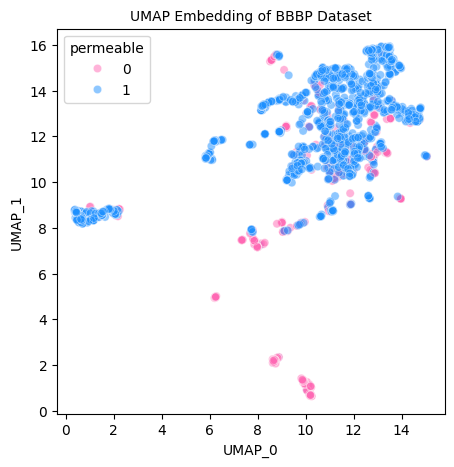

In [9]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
plt.figure(figsize=(5, 5))
sns.scatterplot(data=bbbp,
                x="UMAP_0",
                y="UMAP_1",
                hue="permeable",
                alpha=0.5,
                palette=palette)
plt.title(f"UMAP Embedding of BBBP Dataset", fontsize=10)
plt.show()

## 5. Project compounds of interest onto the existing UMAP

Here, we select a few compounds of interest and calculate their ECFP descriptors to embed them into the existing UMAP.

**TODO**:
1. Project (transform) the compund ECFP descriptors onto the previously calculated UMAP.

**Source of smiles descriptors**:
At [PubChem](https://pubchem.ncbi.nlm.nih.gov/) you can find smiles descriptors for chemical compounds.

In [ ]:
# embed a few compounds of interest into the umap
compounds_of_interest = pd.DataFrame()
compounds_of_interest["name"] = [
    "Caffeine (1)", 
    "Penicillin G (0)", 
    "Ethanol (1)",
    "Gold"
    ]
compounds_of_interest["smiles"] = [
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C", 
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C", 
    "CCO",
    "[Au]"
    ]
# 0 for non-permeable, 1 for permeable, 2 for undefined
compounds_of_interest["permeable"] = [
    1, 
    0, 
    1,
    2
    ]
compounds_of_interest

,name,smiles,permeable
0,Caffeine (1),CN1C=NC2=C1C(=O)N(C(=O)N2C)C,1
1,Penicillin G (0),CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...,0
2,Ethanol (1),CCO,1
3,Gold,[Au],2


In [11]:
ecfp_compounds_of_interest, keep_idx = compute_ecfp_descriptors(compounds_of_interest["smiles"])

# Only keep those that sucessfully featurized
compounds_of_interest = compounds_of_interest.iloc[keep_idx]

pd.DataFrame(ecfp_compounds_of_interest)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
transformed_compounds_of_interest = umap_reducer.transform(ecfp_compounds_of_interest) #TODO use the transform method of the umap_reducer object to transform the ecfp_compounds_of_interest
compounds_of_interest["UMAP_0"], compounds_of_interest["UMAP_1"] = transformed_compounds_of_interest[:,0], transformed_compounds_of_interest[:,1]
compounds_of_interest

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,name,smiles,permeable,UMAP_0,UMAP_1
0,Caffeine (1),CN1C=NC2=C1C(=O)N(C(=O)N2C)C,1,11.173377,8.758865
1,Penicillin G (0),CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...,0,8.540023,2.298836
2,Ethanol (1),CCO,1,9.479440,10.702671
3,Gold,[Au],2,7.780522,7.321814


C:\Users\marqu\AppData\Local\Temp\ipykernel_26908\3088221656.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=bbbp,


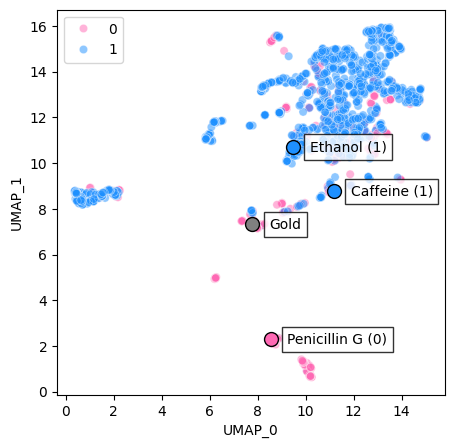

In [13]:
plt.figure(figsize=(5, 5))
palette = sns.color_palette(["hotpink", "dodgerblue", "grey"])
sns.scatterplot(data=bbbp,
                x="UMAP_0",
                y="UMAP_1",
                hue="permeable",
                alpha=0.5,
                palette=palette)
colors = ["black", "red", "blue", "green"]
for i, row in compounds_of_interest.iterrows():
    plt.scatter(row["UMAP_0"], row["UMAP_1"], s=100, edgecolor='black', facecolor=palette[row["permeable"]])
    # add text next to the point with textbox around that has alpha 0.5
    plt.text(row["UMAP_0"] + 0.7, row["UMAP_1"], row["name"], fontsize=10, va='center', bbox=dict(facecolor='white', alpha=0.8))
plt.legend()
plt.show()


#TODO (for fast people): Go to PubChem and find a molecule of interest, compute its ECFP descriptors and embed it into the UMAP plot.

Takeaway from this last section:  
We can project own compounds of interest onto the existing UMAP embedding and by this see, if the compounds of interest are close in terms of their structure to other compounds in the BBBP dataset.